# Credit card fraud detection models

## Dataset's author info

Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import pandas as pd
import numpy as np
import os
import pickle

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
# my plotting functions

from functions.fraud_plots import (
    plot_correlations, 
    correlation_heatmap, 
    generate_grid_set, 
    plot_2d_scatter,
    plot_3d_scatter,  
    plot_density,
    plot_confusion_matrix, 
    plot_roc_curve, 
    plot_precision_recall_vs_threshold, 
    plot_pr_curve
)

In [3]:
data = pd.read_csv('data/creditcard_subset.csv')

## Data analysis

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,127614.0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,...,-0.038661,-0.127194,0.036464,0.504076,0.176423,0.541252,-0.121212,-0.064948,64.99,0
1,139389.0,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,...,-0.196288,0.015015,0.197023,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,1.00,0
2,68482.0,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627286,2.452801,0.319063,...,-0.223384,-0.441265,0.250283,0.091483,-0.038373,-0.410096,0.088944,0.026973,30.70,0
3,123677.0,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,...,0.297749,0.633531,-0.176001,0.146116,0.342753,0.198887,-0.117734,-0.061706,154.09,0
4,121222.0,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,...,-0.338599,-0.220436,0.112804,0.049313,0.157236,0.606729,-0.063450,-0.071105,10.00,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213605 entries, 0 to 213604
Data columns (total 31 columns):
Time      213605 non-null float64
V1        213605 non-null float64
V2        213605 non-null float64
V3        213605 non-null float64
V4        213605 non-null float64
V5        213605 non-null float64
V6        213605 non-null float64
V7        213605 non-null float64
V8        213605 non-null float64
V9        213605 non-null float64
V10       213605 non-null float64
V11       213605 non-null float64
V12       213605 non-null float64
V13       213605 non-null float64
V14       213605 non-null float64
V15       213605 non-null float64
V16       213605 non-null float64
V17       213605 non-null float64
V18       213605 non-null float64
V19       213605 non-null float64
V20       213605 non-null float64
V21       213605 non-null float64
V22       213605 non-null float64
V23       213605 non-null float64
V24       213605 non-null float64
V25       213605 non-null float64
V26  

In [6]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,...,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,94763.710592,0.000761,-0.000864,-0.000395,-0.000124,0.000037,-0.001235,-0.000793,0.000741,0.002086,...,0.000008,0.000888,-0.000716,-0.000077,0.000786,0.000293,-0.000320,-0.000183,88.408696,0.001727
std,47521.370536,1.959843,1.656822,1.514786,1.412014,1.367172,1.324434,1.218273,1.194886,1.098027,...,0.729790,0.726021,0.632531,0.605641,0.522326,0.482457,0.401070,0.328280,248.726927,0.041527
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-50.943369,-13.434066,...,-22.889347,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54113.000000,-0.919923,-0.597928,-0.891674,-0.845828,-0.693702,-0.768408,-0.555589,-0.208845,-0.639825,...,-0.228160,-0.541214,-0.161916,-0.353719,-0.316995,-0.327013,-0.070970,-0.052880,5.580000,0.000000
50%,84629.000000,0.019950,0.065295,0.180284,-0.018836,-0.055078,-0.274951,0.040626,0.022431,-0.048788,...,-0.029198,0.007580,-0.011943,0.041112,0.017457,-0.052342,0.001158,0.011244,22.000000,0.000000
75%,139282.000000,1.315599,0.803606,1.028480,0.743107,0.611668,0.398198,0.569214,0.327296,0.599340,...,0.186690,0.527844,0.146825,0.439075,0.352142,0.241358,0.090808,0.078129,77.010000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,23.917837,44.054461,19.587773,15.594995,...,27.202839,8.361985,20.803344,4.016342,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [7]:
data['Class'].value_counts()

0    213236
1       369
Name: Class, dtype: int64

In [8]:
len(data[data['Class'] == 1])/len(data)*100

0.17274876524425925

It's true that the dataset is highly unbalanced, the positive class (frauds) make only 0.173% of all transactions.

### Change seconds to hours

In [9]:
new_time = [i//(3600) for i in data['Time'].values]
data['Time'] = new_time

### Density

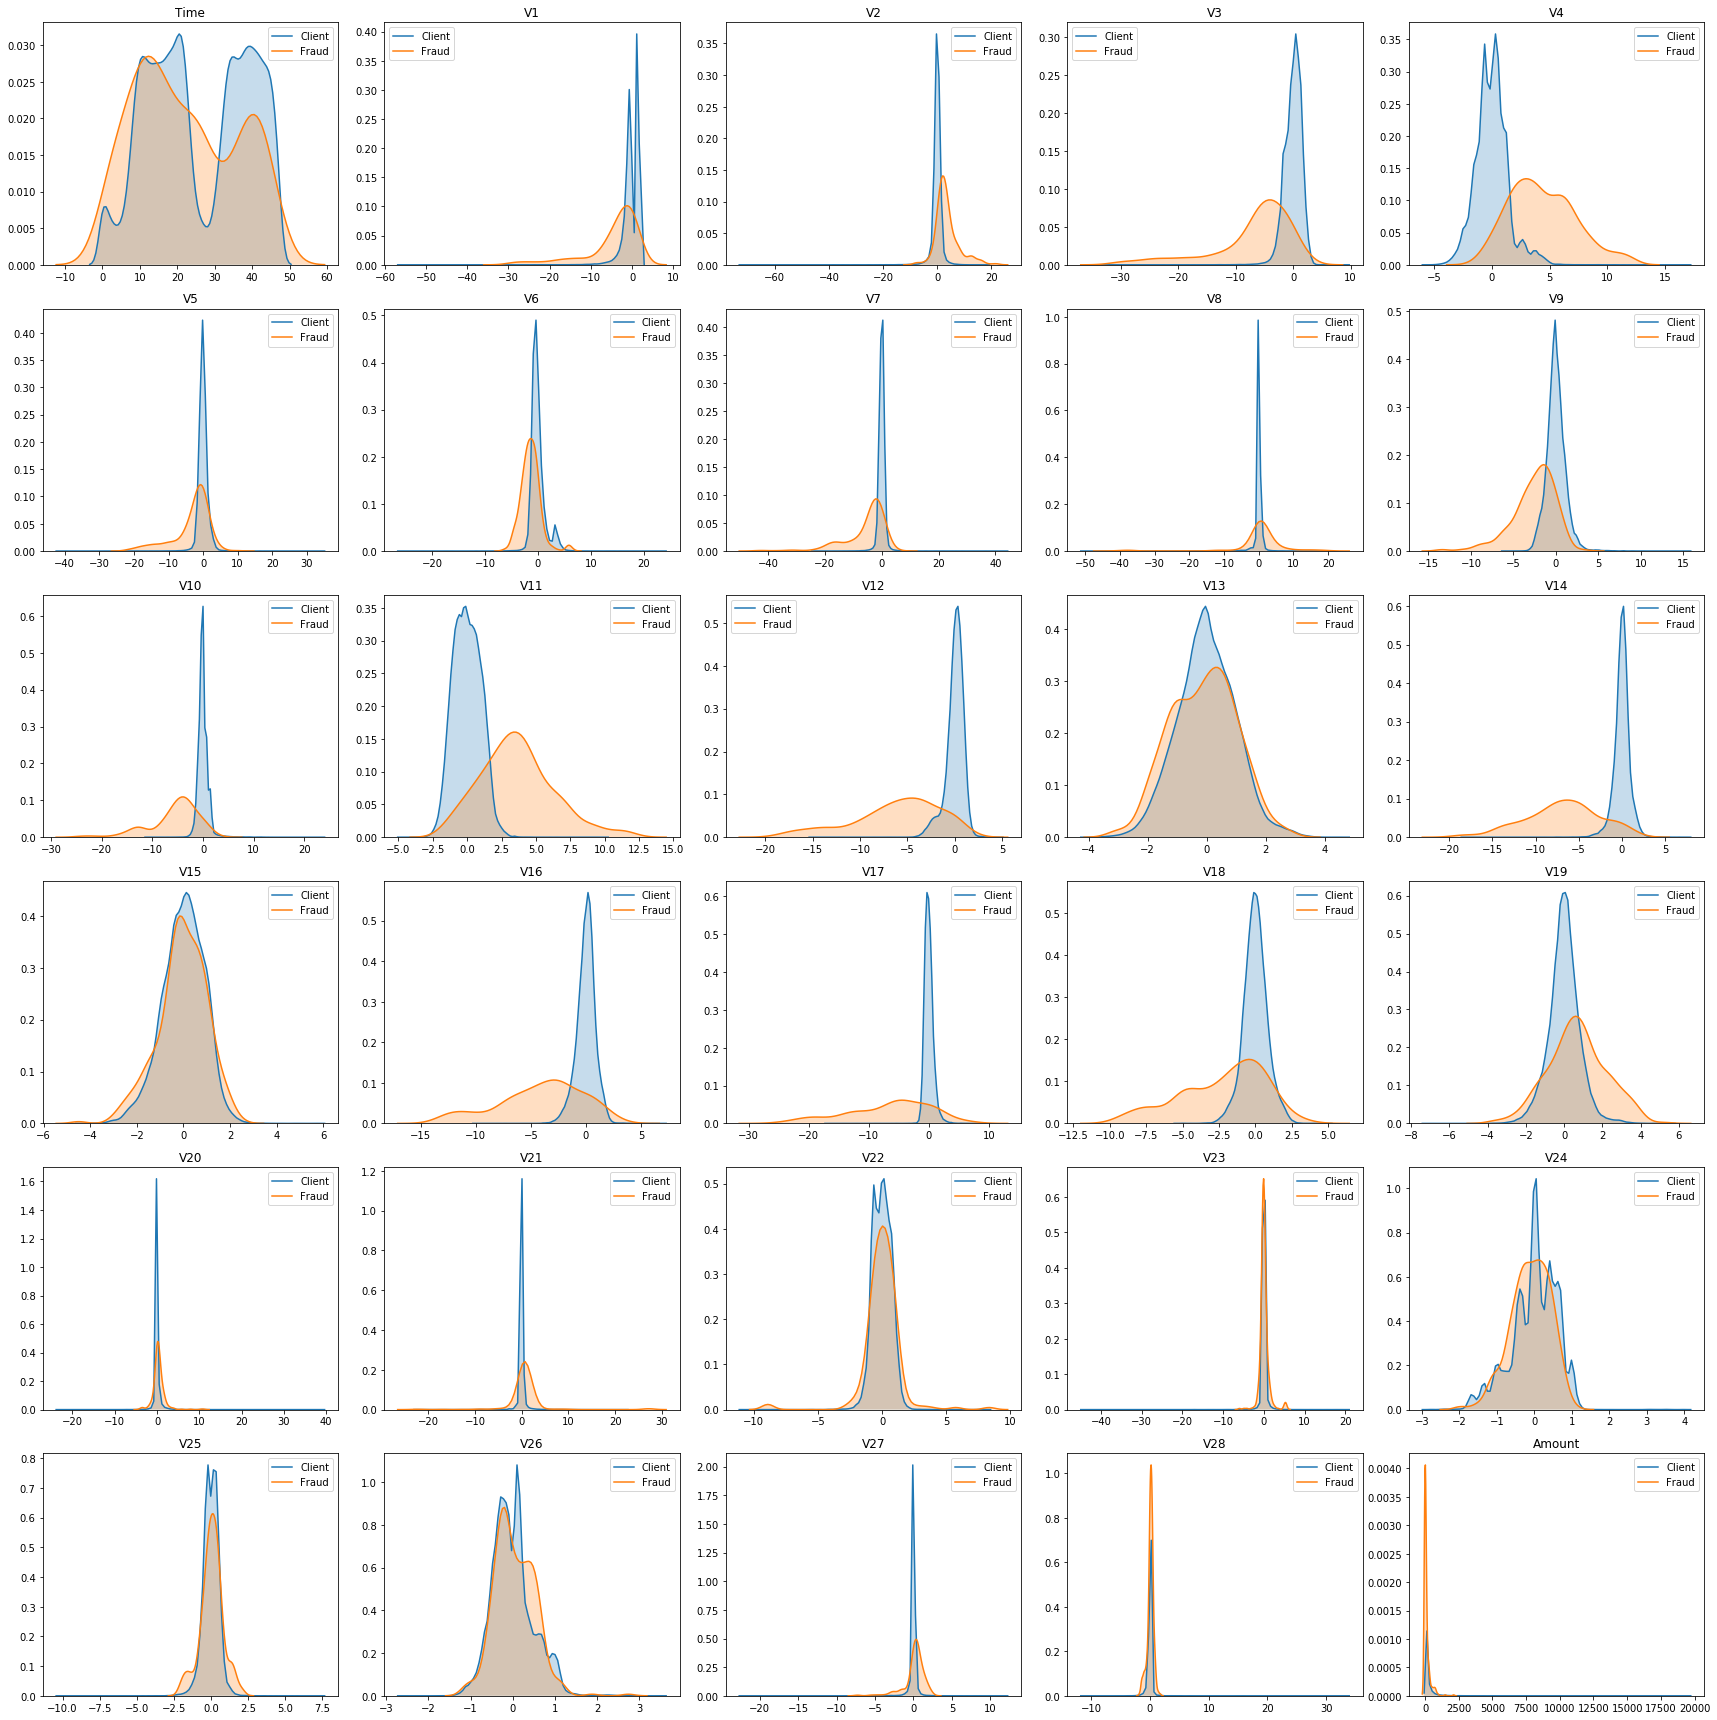

In [10]:
plot_density(data, list(data.columns.values)[:-1])

Coclusions from density plots gives more info about data distribution. Columns $V_{4}$,  $V_{12}$,  $V_{14}$, $V_{16}$ and  $V_{17}$ are the most significant ones.

### Rename classes

In [11]:
from functions.replace_values_in_column import replace_values_in_column

data['Class'] = replace_values_in_column(data['Class'], [[1,-1], [0, 1]])

Labels have changed due to the subsequent use of Isolation Forest, which generates results {-1, 1}.

### Train test split

In [12]:
from functions.split_dataset import split_dataset

X_train, y_train, X_test, y_test = split_dataset(data)

### Standarization of numerical data

Standardization will make our SVM model faster. It is important because we have features with different ranges in dataset.|

In [13]:
from functions.scale_data import scale_data

X_train = scale_data(X_train)
X_test = scale_data(X_test)

X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
137200,0.619987,-0.538694,1.085323,-1.144500,-0.879551,0.525655,-0.986156,0.728634,0.397219,-0.691801,...,-0.189659,0.466043,1.290479,-0.293770,-0.717792,-0.331278,0.195053,0.283487,0.570010,0.77
100303,0.012854,-1.516929,1.075782,-0.085666,-0.077466,1.513248,-0.236273,-0.300005,-4.308382,0.293307,...,-2.536982,5.992309,-1.722575,-0.815726,-0.654558,2.919863,-0.708198,1.374457,-0.357860,36.00
81814,1.075337,-0.431065,0.324544,0.334648,-2.422990,-0.102627,-0.611116,0.167487,0.447162,1.024186,...,-0.286645,-0.159945,-0.448120,-0.014184,-0.873959,-0.868571,-1.633736,0.681785,0.480526,5.77
79245,1.606579,0.890191,-0.754151,-0.314763,0.421457,-0.795660,0.082515,-0.717952,0.112495,-0.214974,...,-0.525998,-0.030037,0.189098,0.087467,-0.787403,-0.563846,-1.174338,0.113531,-0.043193,158.00
157671,0.392312,0.004007,0.067442,0.671859,-0.771623,0.168640,-0.117299,0.265301,0.019034,0.630311,...,-0.323901,0.525088,1.810067,-0.142183,-0.621480,-2.439638,0.682491,0.134223,0.064216,5.99


### Correlations

In [14]:
corr_matrix = data.corr()
correlations = corr_matrix['Class'].sort_values(ascending=False).drop('Class')

important_correlations_with_class = correlations[abs(corr_matrix.sum(axis=1)) > sorted(abs(corr_matrix.sum(axis=1)))[-20]]

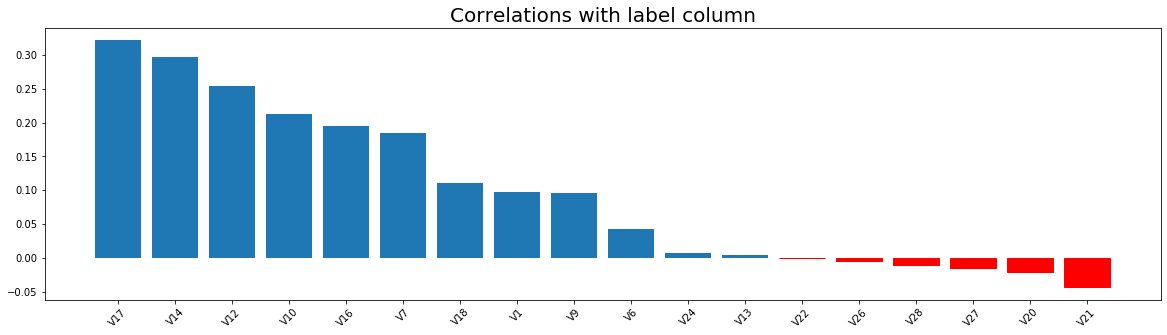

In [15]:
plot_correlations(important_correlations_with_class)

In [16]:
dict_of_max_values = {}
for i in corr_matrix.columns:
    largest = abs(corr_matrix[i]).nlargest(2)
    dict_of_max_values[largest.index[0]] = largest[1]
important_correlations = [i[0] for i in sorted(dict_of_max_values.items(), key=lambda kv: kv[1])[-12:]]

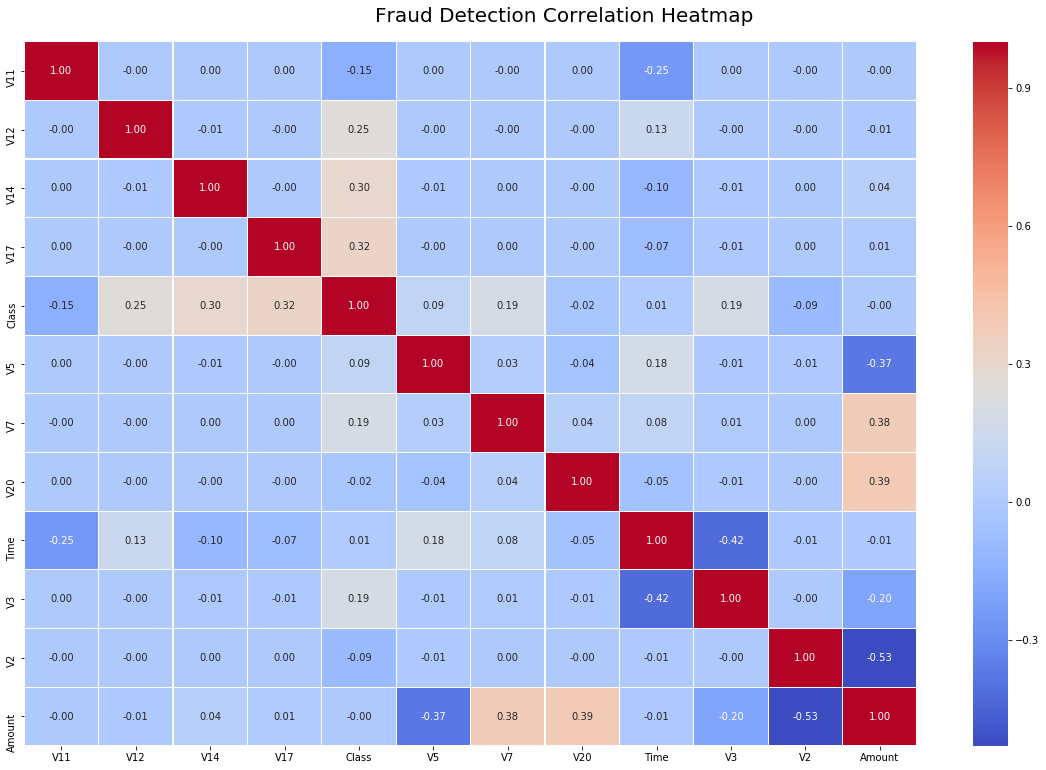

In [17]:
correlation_heatmap(corr_matrix.loc[important_correlations, important_correlations])

Visualization of correlation matrix could help us to understand rest of the features. For instance $V_{2}$ feature is higly correlated with $Amount$ and $V_{3}$ is highly correlated with $Time$. 

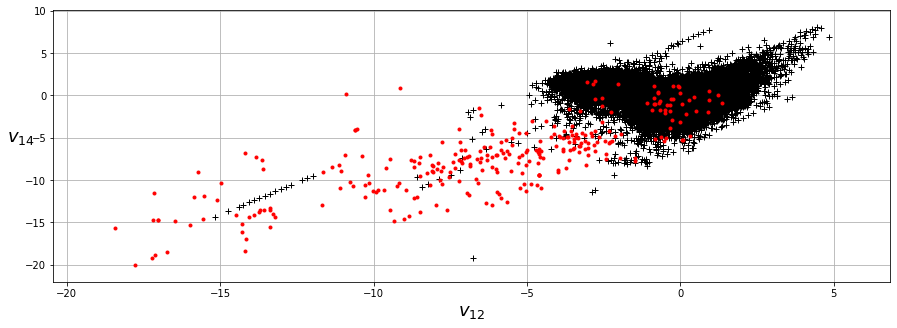

In [18]:
plot_2d_scatter(X_train, y_train, 'V12', 'V14', "$v_{12}$", "$v_{14}$")

2D visualization based on two most correlated with $Class$ features.

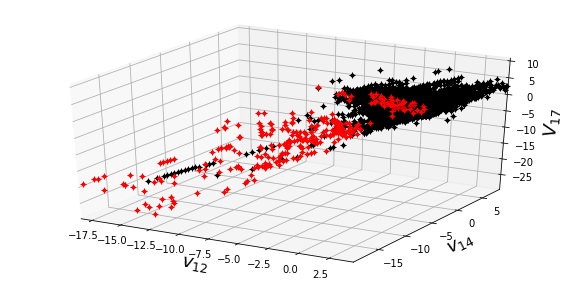

In [19]:
plot_3d_scatter(X_train, y_train, 'V12', 'V14', 'V17', "$v_{12}$", "$v_{14}$", "$V_{17}$")

3D visualization based on three most correlated with $Class$ features.

### Data resampling

In [20]:
from functions.load_or_train import resample_data
X_train_resampled, y_train_resampled = resample_data(X_train, y_train['Class'])

Using TensorFlow backend.


In [21]:
data_train_resampled = np.c_[X_train_resampled, y_train_resampled]
data_train_resampled = pd.DataFrame(data_train_resampled, columns=data.columns.values)

### Corelation scatter plots after resampling

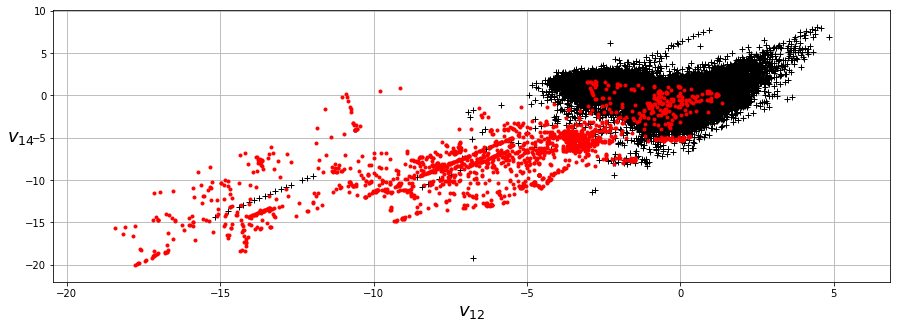

In [22]:
plot_2d_scatter(data_train_resampled, data_train_resampled['Class'], 'V12', 'V14', "$v_{12}$", "$v_{14}$")

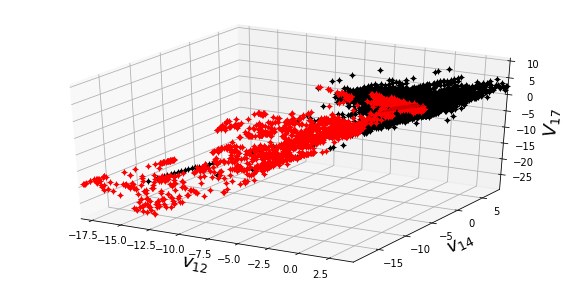

In [23]:
plot_3d_scatter(data_train_resampled, data_train_resampled['Class'], 'V12', 'V14', 'V17', "$v_{12}$", "$v_{14}$", "$V_{17}$")

The blurring of borders is not surprising. Please note that our training set consists of 30 features, and we present only 2 or 3 of them in visualizations.

## Preparation for comparing predicting models

In [24]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (
    GradientBoostingClassifier, 
    RandomForestClassifier,
    VotingClassifier, 
    IsolationForest
)

from sklearn.metrics import (
    precision_score, 
    recall_score,
    f1_score, 
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve
)

from functions.model_functions import (
    prepare_model,
    model_tests, 
    transform_to_orginal
)

from functions.n_data_splits import n_data_splits
from scipy.integrate import trapz
from mlxtend.classifier import EnsembleVoteClassifier

## Training models

In [25]:
models_dir = os.getcwd() + '/models'

In [26]:
if 'clf_logistic_regression.sav' in os.listdir(models_dir):
    clf_logistic_regression = pickle.load(open(models_dir + '/clf_logistic_regression.sav', 'rb'))
else:
    clf_logistic_regression = prepare_model(LogisticRegression(), 
                                            {'solver':['lbfgs','sag', 'saga'], 
                                             'max_iter':[1e4]}, 
                                            X_train_resampled, 
                                            y_train_resampled)
    
    filename = models_dir + '/clf_logistic_regression.sav'
    pickle.dump(clf_logistic_regression, open(filename, 'wb'))

In [27]:
if 'clf_decision_tree.sav' in os.listdir(models_dir):
    clf_decision_tree = pickle.load(open(models_dir + '/clf_decision_tree.sav', 'rb'))
else:
    clf_decision_tree = prepare_model(DecisionTreeClassifier(), 
                                      {'min_samples_split':[20, 390, 1000], 
                                       'max_depth':[None, 5, 10, 20],
                                       'random_state':[12]}, 
                                      X_train_resampled, 
                                      y_train_resampled)
    
    filename = models_dir + '/clf_decision_tree.sav'
    pickle.dump(clf_decision_tree, open(filename, 'wb'))

In [28]:
if 'clf_svc.sav' in os.listdir(models_dir):
    clf_svc = pickle.load(open(models_dir + '/clf_svc.sav', 'rb'))
else:
    clf_svc = prepare_model(SVC(), 
                            {'C':[1.0, 2.0], 
                             'class_weight':['balanced'],
                             'random_state':[12],
                             'gamma':['scale'],
                             'kernel':['poly', 'rbf', 'sigmoid']},
                            X_train_resampled, 
                            y_train_resampled)
    
    filename = models_dir + '/clf_svc.sav'
    pickle.dump(clf_svc, open(filename, 'wb'))

In [29]:
if 'clf_sgd.sav' in os.listdir(models_dir):
    clf_sgd = pickle.load(open(models_dir + '/clf_sgd.sav', 'rb'))
else:
    clf_sgd = prepare_model(SGDClassifier(), 
                            {'penalty':['l1', 'l2', 'elasticnet'],
                             'alpha':[0.0001, 0.01],
                             'random_state':[12]},
                            X_train_resampled, 
                            y_train_resampled)
    
    filename = models_dir + '/clf_sgd.sav'
    pickle.dump(clf_sgd, open(filename, 'wb'))

In [30]:
if 'clf_gausian.sav' in os.listdir(models_dir):
    clf_gausian = pickle.load(open(models_dir + '/clf_gausian.sav', 'rb'))
else:
    clf_gausian = prepare_model(GaussianNB(), 
                                {'priors':[None]},
                                X_train_resampled, 
                                y_train_resampled)
    
    filename = models_dir + '/clf_gausian.sav'
    pickle.dump(clf_gausian, open(filename, 'wb'))

In [31]:
if 'clf_knn.sav' in os.listdir(models_dir):
    clf_knn = pickle.load(open(models_dir + '/clf_knn.sav', 'rb'))
else:
    clf_knn = prepare_model(KNeighborsClassifier(), 
                                {'n_neighbors':[1, 3, 5, 7],
                                'weights':['uniform', 'distance'],
                                'p':[1, 2]},
                                X_train_resampled, 
                                y_train_resampled)
    
    filename = models_dir + '/clf_knn.sav'
    pickle.dump(clf_knn, open(filename, 'wb'))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 119.9min finished


In [32]:
if 'clf_gradient_boosting.sav' in os.listdir(models_dir):
    clf_gradient_boosting = pickle.load(open(models_dir + '/clf_gradient_boosting.sav', 'rb'))
else:
    clf_gradient_boosting = prepare_model(GradientBoostingClassifier(), 
                                          {'learning_rate':[0.1, 0.05],
                                           'max_depth':[None, 10], 
                                           'n_estimators':[100, 200],
                                           'random_state':[12]},
                                          X_train_resampled, 
                                          y_train_resampled)
    
    filename = models_dir + '/clf_gradient_boosting.sav'
    pickle.dump(clf_gradient_boosting, open(filename, 'wb'))

In [33]:
if 'clf_random_forest.sav' in os.listdir(models_dir):
    clf_random_forest = pickle.load(open(models_dir + '/clf_random_forest.sav', 'rb'))
else:
    clf_random_forest = prepare_model(RandomForestClassifier(), 
                                      {'max_depth':[None, 10, 15], 
                                       'n_estimators':[100, 200],
                                       'random_state':[12], 
                                       'criterion':['gini','entropy']},
                                      X_train_resampled, 
                                      y_train_resampled)
    
    filename = models_dir + '/clf_random_forest.sav'
    pickle.dump(clf_random_forest, open(filename, 'wb'))

In [34]:
if 'clf_isolation_forest.sav' in os.listdir(models_dir):
    clf_isolation_forest = pickle.load(open(models_dir + '/clf_isolation_forest.sav', 'rb'))
else:
    clf_isolation_forest = IsolationForest(contamination=0.0017, max_samples='auto',
                          verbose=1, behaviour="new")
    clf_isolation_forest.fit(X_train_resampled)
    
    filename = models_dir + '/clf_isolation_forest.sav'
    pickle.dump(clf_isolation_forest, open(filename, 'wb'))

## Models evaluation

### Single classifiers

In [35]:
model_tests(clf_logistic_regression, X_test, y_test)

Best params: 	 {'clf__max_iter': 10000.0, 'clf__solver': 'lbfgs'}

Precision score: 	 0.828125
Recall score: 	 0.7162162162162162
F1 score: 	 0.7681159420289855
F_beta score: 	 0.75

Roc AUC Score: 	 0.857979142412983

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.83      0.72      0.77        74

    accuracy                           1.00     42721
   macro avg       0.91      0.86      0.88     42721
weighted avg       1.00      1.00      1.00     42721



Logistic regression is doing really well for such a simple model.

In [36]:
model_tests(clf_decision_tree, X_test, y_test)

Best params: 	 {'clf__max_depth': 5, 'clf__min_samples_split': 20, 'clf__random_state': 12}

Precision score: 	 0.873015873015873
Recall score: 	 0.7432432432432432
F1 score: 	 0.8029197080291971
F_beta score: 	 0.7819905213270142

Roc AUC Score: 	 0.8715278283888033

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.87      0.74      0.80        74

    accuracy                           1.00     42721
   macro avg       0.94      0.87      0.90     42721
weighted avg       1.00      1.00      1.00     42721



Decision tree works greate. Probably random forest will be even better.

In [37]:
model_tests(clf_svc, X_test, y_test, mode=1)

Best params: 	 {'clf__C': 1.0, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'clf__random_state': 12}

Precision score: 	 0.12896405919661733
Recall score: 	 0.8243243243243243
F1 score: 	 0.22303473491773307
F_beta score: 	 0.2946859903381643

Roc AUC Score: 	 0.9073318106720222


For kernel: 'rbf' value depends only on the distance between the input and some fixed point. Seems that it's not enough for our data, beacause increasing recall score highly decreased precision score for fraud detections.

In [38]:
model_tests(clf_sgd, X_test, y_test, mode=1)

Best params: 	 {'clf__alpha': 0.0001, 'clf__penalty': 'l1', 'clf__random_state': 12}

Precision score: 	 0.4634146341463415
Recall score: 	 0.7702702702702703
F1 score: 	 0.5786802030456852
F_beta score: 	 0.6309963099630997

Roc AUC Score: 	 0.8843613409643846


In essence gradient descent is kind of a greedy approach. The gradient is nothing but the direction along which the loss function decreases the fastest, and descending this means finding the locally optimal choice at each iteration.There is no guarantee that the optimization algorithm will find a global minimum. If loss function is not convex function our data could be too complex to train model with high recall and sufficient precision.

In [39]:
model_tests(clf_gausian, X_test, y_test, mode=1)

Best params: 	 {'clf__priors': None}

Precision score: 	 0.06043956043956044
Recall score: 	 0.7432432432432432
F1 score: 	 0.11178861788617886
F_beta score: 	 0.15595463137996218

Roc AUC Score: 	 0.8615974698641709


Naive Bayes assumes that all features are independent, so if the variables are correlated, the predictions will be weak. Our data functions are mostly PCA breakdown results, so it was obvious that this model would not be good enough.

In [40]:
model_tests(clf_knn, X_test, y_test)

Best params: 	 {'clf__n_neighbors': 1, 'clf__p': 1, 'clf__weights': 'uniform'}

Precision score: 	 0.8125
Recall score: 	 0.7027027027027027
F1 score: 	 0.7536231884057971
F_beta score: 	 0.7358490566037736

Roc AUC Score: 	 0.8512106615021239

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.81      0.70      0.75        74

    accuracy                           1.00     42721
   macro avg       0.91      0.85      0.88     42721
weighted avg       1.00      1.00      1.00     42721



### Ensembled classifiers

Individual models gave us a high recall, but the precision was insufficient. People don't like being disturbed, so we can't take action against users knowing that only 1 in 20 suspects are really guilty. Ensembled classifiers could be helpful in increasing our precision withou decreasing recall.

In [41]:
model_tests(clf_gradient_boosting, X_test, y_test)

Best params: 	 {'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__random_state': 12}

Precision score: 	 0.5283018867924528
Recall score: 	 0.7567567567567568
F1 score: 	 0.6222222222222221
F_beta score: 	 0.6614173228346457

Roc AUC Score: 	 0.8777921706732643

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.53      0.76      0.62        74

    accuracy                           1.00     42721
   macro avg       0.76      0.88      0.81     42721
weighted avg       1.00      1.00      1.00     42721



Gradient Boosting is a method, which builds on weak classifiers. The idea is to add a classifier at a time, so that the next classifier is trained to improve the already trained ensemble. In this way we increased complexity of our model, however now it has much better precision.

In [42]:
model_tests(clf_random_forest, X_test, y_test)

Best params: 	 {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__n_estimators': 200, 'clf__random_state': 12}

Precision score: 	 1.0
Recall score: 	 0.7567567567567568
F1 score: 	 0.8615384615384616
F_beta score: 	 0.823529411764706

Roc AUC Score: 	 0.8783783783783784

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       1.00      0.76      0.86        74

    accuracy                           1.00     42721
   macro avg       1.00      0.88      0.93     42721
weighted avg       1.00      1.00      1.00     42721



Random forests outperform single decision trees because:

$\cdot$ Trees are unpruned. A random forest tree is fully grown and unpruned, what brings about the feature space is split into more and smaller regions.

$\cdot$ Trees are diverse. Each random forest tree is learned on a random sample, and at each node, a random set of features are considered for splitting. 

Both mechanisms create diversity among the trees. Unpruned and diverse trees lead to a high resolution in the feature space. For continuous features, it means a smoother decision boundary.

In [43]:
model_tests(clf_isolation_forest, X_test, y_test, from_grid=False)

Precision score: 	 0.6875
Recall score: 	 0.14864864864864866
F1 score: 	 0.24444444444444446
F_beta score: 	 0.201219512195122

Roc AUC Score: 	 0.5742657035538129

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.69      0.15      0.24        74

    accuracy                           1.00     42721
   macro avg       0.84      0.57      0.62     42721
weighted avg       1.00      1.00      1.00     42721



Confusion matrix, without normalization
[[42642     5]
 [   63    11]]


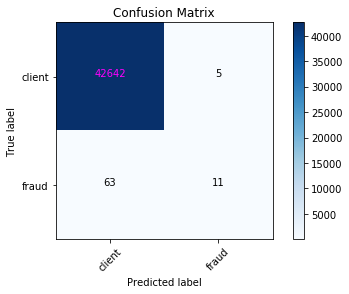

In [44]:
predictions = clf_isolation_forest.predict(X_test)
predictions, y_test_original = transform_to_orginal(predictions, y_test.values)

cm = confusion_matrix(y_test_original, predictions)
plot_confusion_matrix(cm, ['client', 'fraud'], title='Confusion Matrix')

### Voting Classifiers with evaluation

We managed to train two models with much better results than the previous ones. Now we could try to combine them into one classifier. It is highly possible that the result can give us even more satisfactory predictions.

In [46]:
if 'voting_clf.sav' in os.listdir(models_dir):
    voting_clf = pickle.load(open(models_dir + '/voting_clf.sav', 'rb'))
else:
    voting_clf = VotingClassifier(estimators=[
        ('p1', clf_logistic_regression[2]), 
        ('p2', clf_random_forest[2]),
        ('p3', clf_random_forest[2])
    ], voting='soft')
    
    voting_clf.fit(X_train_resampled, y_train_resampled)

    filename = models_dir + '/voting_clf.sav'
    pickle.dump(voting_clf, open(filename, 'wb'))
    
model_tests(voting_clf, X_test, y_test, from_grid=False)

Precision score: 	 0.9473684210526315
Recall score: 	 0.7297297297297297
F1 score: 	 0.8244274809160306
F_beta score: 	 0.7902439024390243

Roc AUC Score: 	 0.8648296924025581

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.95      0.73      0.82        74

    accuracy                           1.00     42721
   macro avg       0.97      0.86      0.91     42721
weighted avg       1.00      1.00      1.00     42721



F1-score for this model is 0.02 wore than for Random Forest. Could we do better? 

In [47]:
if 'voting_clf_2.sav' in os.listdir(models_dir):
    voting_clf_2 = pickle.load(open(models_dir + '/voting_clf_2.sav', 'rb'))
else:
    voting_clf_2 = EnsembleVoteClassifier(clfs=[clf_logistic_regression[2], 
                                                clf_random_forest[2],
                                               ], voting='hard', refit=False)
    
    voting_clf_2.fit(X_train_resampled, y_train_resampled)

    filename = models_dir + '/voting_clf_2.sav'
    pickle.dump(voting_clf_2, open(filename, 'wb'))
    
model_tests(voting_clf_2, X_test, y_test, from_grid=False)

Precision score: 	 0.835820895522388
Recall score: 	 0.7567567567567568
F1 score: 	 0.7943262411347517
F_beta score: 	 0.7813953488372092

Roc AUC Score: 	 0.8782494126832533

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.84      0.76      0.79        74

    accuracy                           1.00     42721
   macro avg       0.92      0.88      0.90     42721
weighted avg       1.00      1.00      1.00     42721



We improved recall score by 0.01 and decreased precision by 0.31. It's not good result. 

### Splitting training set into 4 independent sets

Combination of undersampling and oversampling. One of the most important steps in dealing with imbalanced data. We resampled data in 1:4 proportion to split it into four independent training sets.

In [48]:
list_of_training_sets = n_data_splits(data_train_resampled, data.columns.values, 3)

In [49]:
train_dict = {}
for i in range(3):
    train_dict['X_train_' + str(i + 1)] = list_of_training_sets[i][0]
    train_dict['y_train_' + str(i + 1)] = list_of_training_sets[i][1]
    

In [50]:
if 'voting_clf_3.sav' in os.listdir(models_dir):
    voting_clf_3 = pickle.load(open(models_dir + '/voting_clf_3.sav', 'rb'))
else:
    clf_logistic_regression_1 = clf_logistic_regression[2].fit(train_dict['X_train_1'], train_dict['y_train_1'])
    clf_random_forest_1 = clf_random_forest[2].fit(train_dict['X_train_2'], train_dict['y_train_2'])
    
    voting_clf_3 = EnsembleVoteClassifier(clfs=[clf_random_forest_1,
                                                clf_logistic_regression_1
                                               ], voting='soft', refit=False)
    
    voting_clf_3.fit(train_dict['X_train_3'], train_dict['y_train_3'])

    filename = models_dir + '/voting_clf_3.sav'
    pickle.dump(voting_clf_3, open(filename, 'wb'))
    

model_tests(voting_clf_3, X_test, y_test, from_grid=False)

Precision score: 	 0.7887323943661971
Recall score: 	 0.7567567567567568
F1 score: 	 0.7724137931034482
F_beta score: 	 0.7671232876712328

Roc AUC Score: 	 0.8782025160668442

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.79      0.76      0.77        74

    accuracy                           1.00     42721
   macro avg       0.89      0.88      0.89     42721
weighted avg       1.00      1.00      1.00     42721



This model perform much more worse than best aproach from before (Random Forest).

## Plots

We need to return from the notation {-1 (fraud), 1(client)} to the notation {1(fraud), 0(client)}, because the charts offered by the module sklearn.metrics evaluate according to the class equal to 1. 

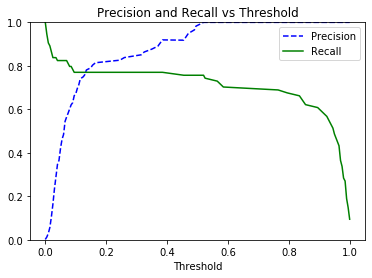

In [73]:
predictions = clf_random_forest[2].predict(X_test)
proba = clf_random_forest[2].predict_proba(X_test)
predictions, y_test_original = transform_to_orginal(predictions, y_test.values)

precisions, recalls, thresholds = precision_recall_curve(y_test_original, proba[:,0])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

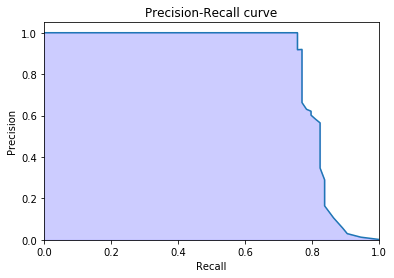

In [74]:
plot_pr_curve(recalls, precisions)

In [75]:
trapz(recalls, precisions)

0.8123636484663748

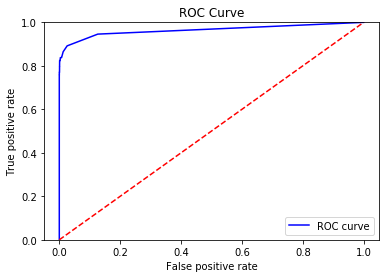

In [81]:
fpr, tpr, _ = roc_curve(y_test_original, proba[:,0])
plot_roc_curve(fpr, tpr)

Confusion matrix, without normalization
[[42647     0]
 [   18    56]]


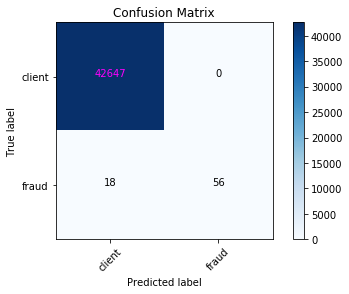

In [78]:
cm = confusion_matrix(y_test_original, predictions)
plot_confusion_matrix(cm, ['client', 'fraud'], title='Confusion Matrix')

Normalized confusion matrix
[[1.         0.        ]
 [0.24324324 0.75675676]]


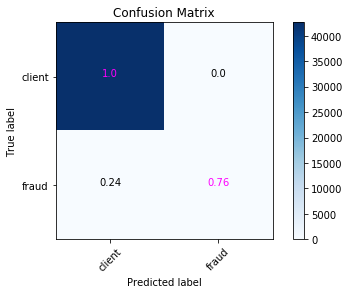

In [79]:
plot_confusion_matrix(cm, ['client', 'fraud'], title='Confusion Matrix', normalize=True)